# Prototyping 1D EFGP 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# y.shape

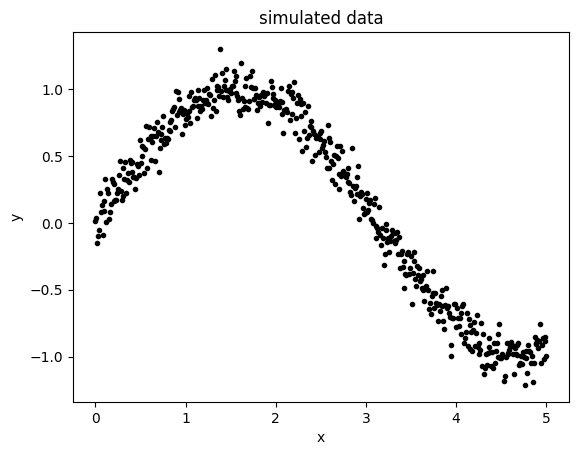

In [3]:
# generate data 
freq = 0.5    
# 1. Generate synthetic data (or use your data)
n = 500
N = n
# Create x as a column vector of shape (50, 1)
x = torch.linspace(0, 5, n, dtype=torch.float64)
# Create synthetic y as noisy sin(x); this gives shape (50, 1)
y = torch.sin(x) + 0.1 * torch.randn(n, dtype=torch.float64)

# plot data
plt.plot(x, y, 'k.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('simulated data')
plt.show()


In [4]:
from utils.kernels import get_xis
from kernels.squared_exponential import SquaredExponential

kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)


In [5]:
# Determine problem geometry
L = x[-1] - x[0]
N = x.shape[0]
EPSILON = 1e-5
xis, h, mtot = get_xis(kernel_obj=kernel, eps=EPSILON, L=L, use_integral=False, l2scaled=False)


In [6]:
print("Mtot: ", mtot)
print("h: ", h)
print("xis: ", xis)

Mtot:  97
h:  tensor(0.1809, dtype=torch.float64)
xis:  tensor([-8.6813, -8.5005, -8.3196, -8.1387, -7.9579, -7.7770, -7.5962, -7.4153,
        -7.2344, -7.0536, -6.8727, -6.6919, -6.5110, -6.3301, -6.1493, -5.9684,
        -5.7876, -5.6067, -5.4258, -5.2450, -5.0641, -4.8832, -4.7024, -4.5215,
        -4.3407, -4.1598, -3.9789, -3.7981, -3.6172, -3.4364, -3.2555, -3.0746,
        -2.8938, -2.7129, -2.5321, -2.3512, -2.1703, -1.9895, -1.8086, -1.6277,
        -1.4469, -1.2660, -1.0852, -0.9043, -0.7234, -0.5426, -0.3617, -0.1809,
         0.0000,  0.1809,  0.3617,  0.5426,  0.7234,  0.9043,  1.0852,  1.2660,
         1.4469,  1.6277,  1.8086,  1.9895,  2.1703,  2.3512,  2.5321,  2.7129,
         2.8938,  3.0746,  3.2555,  3.4364,  3.6172,  3.7981,  3.9789,  4.1598,
         4.3407,  4.5215,  4.7024,  4.8832,  5.0641,  5.2450,  5.4258,  5.6067,
         5.7876,  5.9684,  6.1493,  6.3301,  6.5110,  6.6919,  6.8727,  7.0536,
         7.2344,  7.4153,  7.5962,  7.7770,  7.9579,  8.1387,  8

In [7]:
# minus_mh_to_mh = torch.arange(-((mtot-1)/2)*h, ((mtot-1)/2)*h + h)
# print("minus_mh_to_mh: ", minus_mh_to_mh)
# assert torch.allclose(minus_mh_to_mh, xis), "minus_mh_to_mh and xis are not the same"


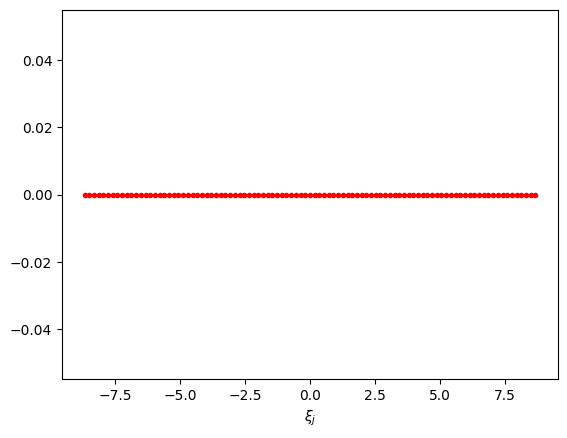

In [8]:
# plot a line with tics on the xis
plt.plot(xis, torch.zeros(mtot), 'r.')
plt.xlabel(r'$\xi_j$')
plt.show()

In [9]:
ws = torch.sqrt(kernel.spectral_density(xis).to(dtype=torch.complex128) * h)
D = torch.diag(ws).to(dtype=torch.complex128)

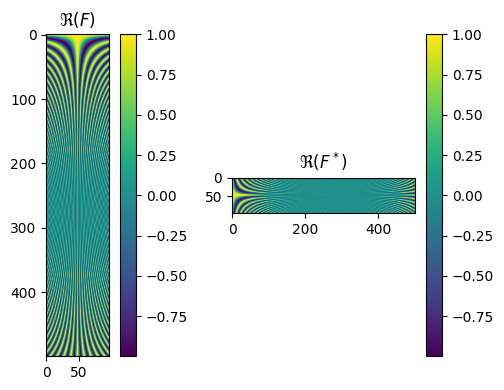

In [10]:
# Form design matrix F
# We do so manually here for clarity (no FFT / NUFFT)
F = torch.exp(1j * 2 * torch.pi * torch.outer(x, xis))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

im1 = ax1.imshow(F.real)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$\Re(F)$')

im2 = ax2.imshow(F.conj().T.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$\Re(F^*)$')

plt.tight_layout()
plt.show()

# ws_diag = torch.diag(ws).to(dtype=Phi.dtype) # complex dtype
# A = ws_diag @ (Phi.T @ Phi) @ ws_diag


In [11]:
# create a matrix of distances between x's
dist_matrix = torch.cdist(x.unsqueeze(-1), x.unsqueeze(-1))
kernel_matrix = kernel.kernel(dist_matrix)

In [12]:
ws = ws.to(dtype=torch.complex128)
F = F.to(dtype=torch.complex128)
A = D @ (torch.conj(F).T @ F) @ D
kernel_approx =  ((F @ torch.diag(ws)) @ (torch.diag(ws) @ torch.conj(F).T))
# right_hand_side = torch.diag(ws) @ (F.adjoint() @ y.to(dtype=torch.complex128))
# beta_test = torch.randn_like(right_hand_side)
# sigmasq = torch.tensor(0.1)
# dense_result = (A + sigmasq * torch.eye(mtot, dtype=A.dtype)) @ beta_test
# from efgp1d import FFTConv1d, compute_convolution_vector_vectorized
# v, j_indices = compute_convolution_vector_vectorized(m=int((mtot - 1) / 2), x=x, h=h)
# Afun = lambda beta: D @ FFTConv1d(v, D @ beta)() + sigmasq * beta
# fft_result = Afun(beta_test)


In [13]:
# print("Dense magnitude:", torch.norm(dense_result))
# print("FFT magnitude:", torch.norm(fft_result))
# print("Dense type:", dense_result.dtype)
# print("FFT type:", fft_result.dtype)

Text(0.5, 0.98, 'Approximating kernel matrix with equispaced features, N = 500, M = 97')

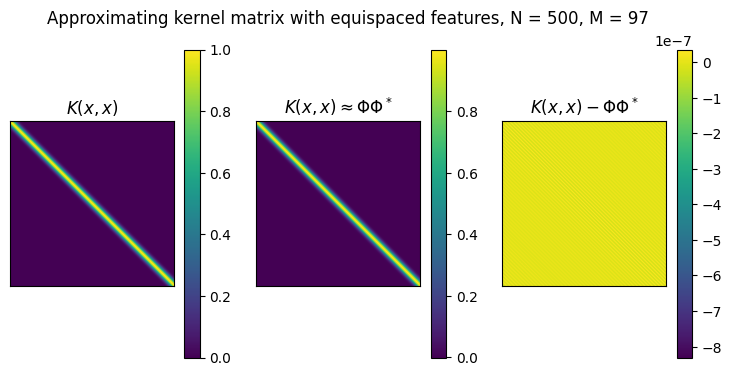

In [14]:
# subplot kernel matrix, kernel approx, and difference side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))

im1 = ax1.imshow(kernel_matrix)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r'$K(x, x)$')
# no axis labels
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(kernel_approx.real)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r'$K(x, x) \approx \Phi \Phi^*$')
ax2.set_xticks([])
ax2.set_yticks([])

diff = kernel_matrix - kernel_approx.real
im3 = ax3.imshow(diff)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r'$K(x, x) - \Phi \Phi^*$')
ax3.set_xticks([])
ax3.set_yticks([])

plt.suptitle(f'Approximating kernel matrix with equispaced features, N = {N}, M = {mtot}')



In [15]:
from efgp_1d_dense import efgp1d_dense
from efgp1d import efgp1d

In [16]:
# make a subset of the data for interpolation and extrapolation
# worked well for N = 200
# x_input = torch.cat([x[:30], x[60:70], x[70:90]])
# y_input = torch.cat([y[:30], y[60:70], y[70:90]])
# for N = 2000
x_input = torch.cat([x[:100], x[300:500], x[650:750]])
y_input = torch.cat([y[:100], y[300:500], y[650:750]])


In [17]:
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta, xis, ytrg, A, F, ws, timing_results = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})

/Users/colecitrenbaum/Documents/GPs/gp-quadrature/efgp_1d_dense.py:87: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Copy.cpp:308.)
  logdet = N*torch.log(sigmasq) + torch.logdet((D @ F.adjoint() @ F @ D)/sigmasq + torch.eye(mtot, dtype=torch.float64)).to(dtype=torch.float64)
/Users/colecitrenbaum/Documents/GPs/gp-quadrature/efgp_1d_dense.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4412.)
  log_marg_lik = -0.5 * y.T @ alpha - 0.5 * logdet - 0.5 * N * torch.log(2 * torch.tensor(torch.pi, dtype=torch.float64))


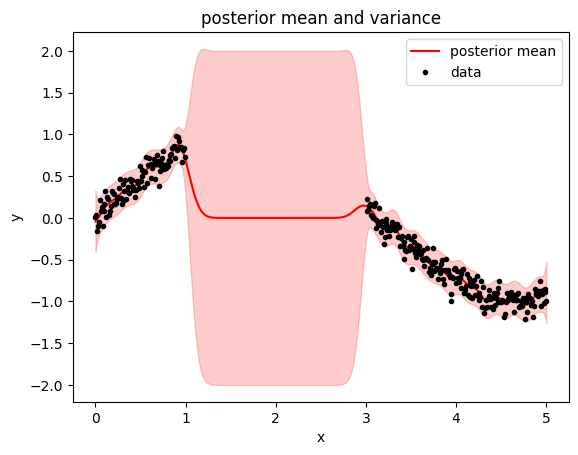

In [18]:
# plot the beta
# plt.plot(x, train_posterior['mean'], 'r-', label='posterior mean')
plt.plot(x, ytrg['mean'], 'r-', label='posterior mean')
# shaded region for +- 2 std
plt.fill_between(x, ytrg['mean'] - 2 * torch.sqrt(ytrg['var']), ytrg['mean'] + 2 * torch.sqrt(ytrg['var']), color='r', alpha=0.2)
plt.plot(x_input, y_input, 'k.', label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('posterior mean and variance')
plt.legend()
plt.show()

In [19]:
# the outputs you get here, for example F, are for the subset of points x_input, not the full x
beta_cg, xis_cg, ytrg_cg, A_cg, F_cg, ws_cg, timing_results_cg = efgp1d_dense(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cg', 'get_log_marginal_likelihood': True})


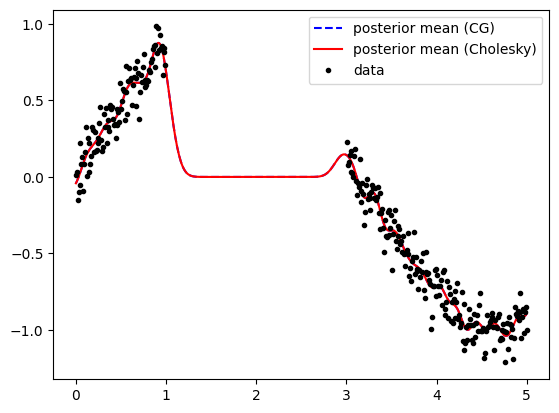

In [20]:
plt.plot(x, ytrg_cg['mean'], 'b--', label='posterior mean (CG)')
plt.plot(x, ytrg['mean'], 'r-', label='posterior mean (Cholesky)')
# plt.fill_between(x, ytrg_cg['mean'] - 2 * torch.sqrt(ytrg_cg['var']), ytrg_cg['mean'] + 2 * torch.sqrt(ytrg_cg['var']), color='b', alpha=0.2)
plt.plot(x_input, y_input, 'k.', label='data')
plt.legend()
plt.show()


In [21]:
assert torch.allclose(ytrg_cg['mean'], ytrg['mean'], atol=1e-8), "ytrg_cg['mean'] and ytrg['mean'] are not the same"

# CG FFT implementation

# hyper opt cole adds

In [22]:
import time
from cg import ConjugateGradients

$$\frac{\partial \mathcal L}{\partial \theta} = \frac{1}{2M} \sum_{k=1}^M z_k^T((K + \sigma^2I)^{-1} \frac{\partial (K + \sigma^2 I)}{\partial \theta}) z_k - \frac{1}{2}y^T (K +\sigma^2 I)^{-1}\frac{\partial (K + \sigma^2 I)}{\partial \theta} (K+\sigma^2I)^{-1}y =I - II $$

In [23]:
# # 
# alpha.conj()

In [24]:
xis, h, mtot = get_xis(kernel, 1e-30, L)
print(xis.shape)

torch.Size([239])


In [25]:
# Z = torch.randint(0, 2, (trace_samples, N), dtype=torch.float64) * 2 - 1
# Z.shape

# here is the main gradient approx, not batched 

In [26]:
import torch
import time
import math
from efgp1d import compute_convolution_vector_vectorized, FFTConv1d



sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
x_new = x 
num_iters = 1
def efgp1d_gradient(x, y, sigmasq, kernel,eps,trace_samples):
    x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
    y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
    x0, x1 = torch.min(x), torch.max(x)
    # opts = {'get_var': True, 'get_log_marginal_likelihood': True}
    L = x1 - x0
    N = x.shape[0]
    # eps = EPSILON
    # eps = 1e-20

    # Get Fourier frequencies and weights.
    xis, h, mtot = get_xis(kernel, eps, L)  # Expect len(xis)=M (e.g., M=97)
    # Compute weights: ws = sqrt(S(xis)*h)
    ws = torch.sqrt(kernel.spectral_density(xis) * h)  # ws: (M,)
    D = torch.diag(ws).to(dtype=torch.complex128)         # D: (M, M)
    
    # Form design features F (size: (N, M)).
    #TODO : use UFFTConv1d instead of this
    F = torch.exp(1j * 2 * math.pi * torch.outer(x, xis)).to(dtype=torch.complex128)

    v, j_indices = compute_convolution_vector_vectorized(m=int((mtot - 1) / 2), x=x, h=h)
    Afun = lambda beta: D @ FFTConv1d(v, D @ beta)() + sigmasq * beta


    # A = D @ (torch.conj(F).T @ F) @ D  # A: (M, M)
    
    # -------------------
    # Compute term 2: the quadratic form.
    rhs = D @ torch.conj(F).T @ y.to(dtype=torch.complex128)  # rhs: (M,)
    # cg_object = ConjugateGradients(
    #     A_apply_function=A + sigmasq * torch.eye(mtot, dtype=A.dtype),
    #     b=rhs,
    #     x0=torch.zeros_like(rhs),
    #     early_stopping=opts.get('early_stopping', False)
    # )
    cg_object = ConjugateGradients(
        A_apply_function=Afun,
        b=rhs,
        x0=torch.zeros_like(rhs),
        early_stopping=False
        # early_stopping=opts.get('early_stopping', False)
    )
    beta = cg_object.solve()  # beta: (M,)
    alpha = 1/sigmasq * (y - F @ D @ beta)  # alpha: (N,)
    
    # -------------------
    Dprime = h * kernel.spectral_grad(xis)  # shape: (M, n_params)
    # This yields the derivative of the diagonal of D^2, since D^2 = diag(S(xis)*h).
    
    # --- Embed each column of Dprime as a diagonal matrix.
    # Dprime is (M, n_params); we want each column (length M) as an (M,M) diagonal.
    # Transpose so each row corresponds to one hyperparameter:
    Dprime_t = Dprime.transpose(0, 1)   # shape: (n_params, M)
    # Embed each row into a diagonal matrix -> (n_params, M, M)
    D_diag_temp = torch.diag_embed(Dprime_t).to(dtype=torch.complex128)  # shape: (n_params, M, M)
    
    # -------------------
    # Compute khat_prime for the kernel hyperparameters:
    # For each hyperparameter i, we want:
    #     khat_prime_i = F * diag(Dprime_i) * F^*
    # Expand F and its conjugate-transpose to include a batch dimension.
    N_val, M_val = F.shape  # M_val should equal M.
    F_expand = F.unsqueeze(0).expand(D_diag_temp.shape[0], N_val, M_val)  # shape: (n_params, N, M)
    F_adjoint = F.conj().transpose(-2, -1)  # shape: (M, N)
    F_adjoint_expand = F_adjoint.unsqueeze(0).expand(D_diag_temp.shape[0], M_val, N_val)  # shape: (n_params, M, N)
    # Batched multiplication:
    khat_prime_kernel = torch.bmm(torch.bmm(F_expand, D_diag_temp), F_adjoint_expand)  # shape: (n_params, N, N)
    
    # Append the noise derivative (for noise, d/dσ² (K+σ²I) = I) as an extra hyperparameter.
    noise_derivative = torch.eye(N, dtype=khat_prime_kernel.dtype).unsqueeze(0)  # shape: (1, N, N)
    khat_prime_kernel_full = torch.cat([khat_prime_kernel, noise_derivative], dim=0)  # shape: (n_params+1, N, N)
    # Optionally, permute so that the hyperparameter dimension is last:
    khat_prime = khat_prime_kernel_full.permute(1, 2, 0)  # shape: (N, N, n_params+1)
    
    # -------------------
    # Compute term 2 (quadratic term) for each hyperparameter:
    # For hyperparameter i, term2_i = α^* (dK/dθ_i) α.
    term2 = torch.zeros(khat_prime.shape[2], dtype=torch.complex128)
    for i in range(khat_prime.shape[2]):
        term2[i] = torch.matmul(alpha.conj().unsqueeze(0),
                                torch.matmul(khat_prime[:, :, i], alpha.unsqueeze(1))).squeeze()
    
    # -------------------
    # Compute term 1 (trace term) via Monte Carlo.
    # trace_samples = 10
    # try with rademachers instead..

    
    # Z = torch.distributions.multivariate_normal.MultivariateNormal(
    #         loc=torch.zeros_like(x),
    #         covariance_matrix=torch.eye(N, dtype=torch.float64)
    #     ).sample([trace_samples])  # shape: (trace_samples, N)
    # sample Z iid rademacher variables shape (trace_samples, N)
    Z = torch.randint(0, 2, (trace_samples, N), dtype=torch.float64) * 2 - 1
    
    term1 = torch.zeros(khat_prime.shape[2], dtype=torch.complex128)
    for i in range(khat_prime.shape[2]):  # for each hyperparameter derivative
        sum_term1 = 0.0 + 0.0j
#TODO: fix the apply function here 
        for j in range(trace_samples):
            z_sample = Z[j, :].to(dtype=torch.complex128)  # shape: (N,)
            temp_rhs = khat_prime[:, :, i] @ z_sample.unsqueeze(1)  # shape: (N, 1)
            rhs_sample = D @ torch.conj(F).T @ temp_rhs  # shape: (M, 1)
            cg_object = ConjugateGradients(
                A_apply_function=Afun,
                b=rhs_sample.squeeze(),  # shape: (M,)
                x0=torch.zeros_like(rhs_sample.squeeze()),
                early_stopping=False
            )
            beta_sample = cg_object.solve()  # shape: (M,)
            # alpha_sample = 1/sigmasq * (y - F @ D @ beta_sample)  # shape: (N,)
            alpha_sample = 1/sigmasq * (temp_rhs.flatten() - F @ D @ beta_sample)

            sum_term1 += torch.dot(z_sample, alpha_sample)
        term1[i] = sum_term1 / trace_samples

    # -------------------
    # Final gradient for each hyperparameter:
    # grad_i = 0.5 * [ term1_i - term2_i ]
    grad = 0.5 * (term1 - term2)
    return grad.real
    # save the gradients for each loop
    # if iter == 0:
    #     grad_all = grad
    # else:
    #     grad_all = torch.cat([grad_all, grad], dim=0)
    
    # Print the gradients.
grad = efgp1d_gradient(x, y, sigmasq, kernel,EPSILON,trace_samples=10)
for i in range(grad.shape[0]):
    print(f"Hyperparameter {i}: gradient approx = {grad[i].real.item():.6f}")


Hyperparameter 0: gradient approx = -817.951604
Hyperparameter 1: gradient approx = 20.018685
Hyperparameter 2: gradient approx = 2037.934003


In [27]:
# grad_all = grad_all.reshape(num_iters,3).real
# # make separate boxplots for each gradient
# # make subplots
# fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# axs[2].boxplot(grad_all[:, 2], positions=[0], widths=0.4, label='noise')
# axs[2].set_title('noise')
# axs[2].set_xticks([])
# axs[1].boxplot(grad_all[:, 1], positions=[0], widths=0.4, label='variance')
# axs[1].set_title('variance')
# axs[1].set_xticks([])
# axs[0].boxplot(grad_all[:, 0], positions=[0], widths=0.4, label='lengthscale')
# axs[0].set_title('length scale')
# axs[0].set_xticks([])
# axs[0].set_ylabel('Gradient')
# plt.suptitle('Boxplots of gradients for each hyperparameter')
# # add lines from true gradients
# # true gradients
# # true_grad = torch.tensor([-0.0001, -0.0001, -0.0001])
# true_grad=  true_grad.real
# # axs[0].axhline(y=true_grad[0], color='r', linestyle='--')
# # axs[1].axhline(y=true_grad[1], color='r', linestyle='--')
# axs[2].axhline(y=true_grad[2], color='r', linestyle='--', label=f'True: {true_grad[2]:.4f}')
# axs[2].legend()
# axs[1].axhline(y=true_grad[1], color='r', linestyle='--', label=f'True: {true_grad[1]:.4f}')
# axs[1].legend()
# axs[0].axhline(y=true_grad[0], color='r', linestyle='--', label=f'True: {true_grad[0]:.4f}')
# axs[0].legend()
# # add legend
# plt.tight_layout()




# started working here on some batching but this is for later
# will have to make fft batched as well

In [28]:
# import torch
# import math
# from cg import BatchConjugateGradients




# # Set up hyperparameters and geometry.
# sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
# kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
# # for iter in range(1):
# def compute_gradients(x, y, sigmasq, kernel, EPSILON):

#     # Flatten data to 1D.
#     x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
#     y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
#     x_new = x 
#     # (x_new can be used for geometry; here we already have x_new)

#     # Problem geometry.
#     # x0, x1 = torch.min(torch.cat([x, x_new])), torch.max(torch.cat([x, x_new]))
#     x0, x1 = torch.min(x), torch.max(x)
#     opts = {'get_var': True, 'get_log_marginal_likelihood': True}
#     L_val = x1 - x0
#     N = x.shape[0]
#     eps = EPSILON
#     eps = 1e-20

#     # Get Fourier frequencies and quadrature weights.
#     xis, h, mtot = get_xis(kernel, eps, L_val)  # Expect len(xis)=M (e.g., M=97)
#     M = len(xis)

#     # Compute spectral density and weights: ws = sqrt(S(xis)*h)
#     ws = torch.sqrt(kernel.spectral_density(xis) * h)  # shape: (M,)
#     D = torch.diag(ws).to(dtype=torch.complex128)         # shape: (M, M)

#     # Form design features F (size: (N, M)):
#     # TODO can form using NUFFT instead 
#     F = torch.exp(1j * 2 * math.pi * torch.outer(x, xis)).to(dtype=torch.complex128)

#     # Compute A = D @ (F^* F) @ D, with F^* = conjugate-transpose of F.
#     A = D @ (torch.conj(F).T @ F) @ D  # shape: (M, M)

#     v, j_indices = compute_convolution_vector_vectorized(m=int((mtot - 1) / 2), x=x, h=h)
#     Afun = lambda beta: D @ FFTConv1d(v, D @ beta)() + sigmasq * beta


#     # -------------------
#     # Compute term 2: the quadratic term.
#     rhs = D @ torch.conj(F).T @ y.to(dtype=torch.complex128)  # shape: (M,)
#     cg_solver = ConjugateGradients(
#         A_apply_function = Afun,
#         b = rhs,
#         x0 = torch.zeros_like(rhs),
#         early_stopping = opts.get('early_stopping', False)
#     )
#     # cg_solver = ConjugateGradients(
#     #     A_apply_function = lambda x: A @ x,
#     #     b = rhs,
#     #     x0 = torch.zeros_like(rhs),
#     #     early_stopping = opts.get('early_stopping', False)
#     # )
#     beta = cg_solver.solve()  # shape: (M,)
#     alpha = 1/sigmasq * (y - F @ D @ beta)  # shape: (N,)

#     # -------------------
#     # Compute derivative of K with respect to kernel hyperparameters.
#     # spectral_grad returns a tensor of shape (M, n_params).
#     Dprime = h * kernel.spectral_grad(xis)  # shape: (M, n_params)
#     # Embed each column of Dprime as a diagonal matrix:
#     Dprime_t = Dprime.transpose(0, 1)  # shape: (n_params, M)
#     D_diag_temp = torch.diag_embed(Dprime_t).to(dtype=torch.complex128)  # shape: (n_params, M, M)

#     # -------------------
#     # Compute khat_prime for kernel hyperparameters:
#     # For each hyperparameter i, khat_prime_i = F * diag(Dprime_i) * F^*
#     # Expand F and its conjugate-transpose to batch over hyperparameters.
#     F_expand = F.unsqueeze(0).expand(D_diag_temp.shape[0], N, M)  # shape: (n_params, N, M)
#     F_adjoint = F.conj().transpose(-2, -1)  # shape: (M, N)
#     F_adjoint_expand = F_adjoint.unsqueeze(0).expand(D_diag_temp.shape[0], M, N)  # shape: (n_params, M, N)
#     khat_prime_kernel = torch.bmm(torch.bmm(F_expand, D_diag_temp), F_adjoint_expand)  # shape: (n_params, N, N)

#     # Append noise derivative (d/d(sigmasq)(K+sigmasqI)=I) as an extra hyperparameter.
#     noise_derivative = torch.eye(N, dtype=khat_prime_kernel.dtype).unsqueeze(0)  # shape: (1, N, N)
#     khat_prime_kernel_full = torch.cat([khat_prime_kernel, noise_derivative], dim=0)  # shape: (n_params+1, N, N)
#     # Permute so that hyperparameter dimension is last.
#     khat_prime = khat_prime_kernel_full.permute(1, 2, 0)  # shape: (N, N, n_params+1)

#     # -------------------
#     # Compute term 2 (quadratic term) for each hyperparameter:
#     # term2_i = α^H * (dK/dθ_i) * α.
#     term2 = torch.zeros(khat_prime.shape[2], dtype=torch.complex128)
#     for i in range(khat_prime.shape[2]):
#         term2[i] = (alpha.conj().unsqueeze(0) @ (khat_prime[:, :, i] @ alpha.unsqueeze(1))).squeeze()

#     # -------------------
#     # Compute term 1 (trace term) via Monte Carlo using batched CG.
#     trace_samples = 10
#     # Sample S random vectors z, shape: (S, N)
#     Z = torch.distributions.MultivariateNormal(
#         loc=torch.zeros(N, dtype=torch.float64),
#         covariance_matrix=torch.eye(N, dtype=torch.float64)
#     ).sample([trace_samples]).to(dtype=torch.complex128)



#     term1 = torch.zeros(khat_prime.shape[2], dtype=torch.complex128)
#     for i in range(khat_prime.shape[2]):
#         # For hyperparameter i, let dK_dtheta = khat_prime[:,:,i] (shape: (N, N))
#         dK_dtheta = khat_prime[:, :, i]  # (N, N)
#         # Compute v for all trace samples: v = dK_dtheta @ Z^T, shape: (N, S)
#         v = dK_dtheta @ Z.T  # (N, S)
#         rhs_batch = D @ (torch.conj(F).T @ v)  # shape: (M, S)

#         B = rhs_batch.shape[1]  # number of right-hand sides = trace_samples
#         # Initial guess x0 for all systems: zeros of shape (B, M)
#         x0_batch = torch.zeros(B, mtot, dtype=torch.complex128)
        
#         # Define a batched A_apply_function: it should accept an input of shape (B, M) and return (B, M)
#         def A_apply_batch(x_batch):
#             # x_batch is of shape (B, M)
#             # We want to compute for each b in batch: (A + sigmasq I) @ x
#             return (A + sigmasq * torch.eye(mtot, dtype=A.dtype)).unsqueeze(0).expand(x_batch.shape[0], -1, -1) @ x_batch.unsqueeze(2)
#             # This returns a shape (B, M, 1); we then squeeze:
#         def A_apply_batch_flat(x_batch):
#             # x_batch: (B, M)
#             Ax = (A + sigmasq * torch.eye(mtot, dtype=A.dtype)).unsqueeze(0).expand(x_batch.shape[0], -1, -1) @ x_batch.unsqueeze(2)
#             return Ax.squeeze(2)
        
#         batch_cg = BatchConjugateGradients(A_apply_function=A_apply_batch_flat,
#                                             b=rhs_batch.T,  # shape: (B, M); note: rhs_batch is (M, S), so transpose to (S, M)
#                                             x0=x0_batch,
#                                             tol=1e-6,
#                                             early_stopping=True)
#         beta_batch = batch_cg.solve()  # shape: (S, M)

#         FD_beta = F @ D @ beta_batch.T  # shape: (N, S)
#         w = 1/sigmasq * (v - FD_beta)  # shape: (N, S)

#         dot_products = torch.sum(torch.conj(Z.T) * w, dim=0)  # shape: (S,)
#         term1[i] = torch.mean(dot_products)
        
#     # -------------------
#     # Final gradient for each hyperparameter:
#         grad = 0.5 * (term1 - term2)
#         return grad 
# grad = compute_gradients(x, y, sigmasq, kernel, EPSILON)
#     # Print the gradients (real parts).
# print("Batched CG-based MC gradients (real parts):")
# print(f"  dNLL/d(lengthscale) = {grad[0].real.item():.6f}")
# if khat_prime.shape[2] > 1:
#     print(f"  dNLL/d(variance)    = {grad[1].real.item():.6f}")
# print(f"  dNLL/d(noise)       = {grad[-1].real.item():.6f}")


# direct inversion using the fourier approximation 
- very similar to auto grad

In [29]:
import torch
import math

def compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON):
    # sigmasq = torch.tensor(0.1, dtype=torch.float64)  # noise variance
    # kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

    # Flatten data to 1D.
    x = x.to(dtype=torch.float64).flatten()   # shape: (N,)
    y = y.to(dtype=torch.float64).flatten()     # shape: (N,)
    x_new = torch.linspace(0, 5, 1000, dtype=torch.float64)

    # Problem geometry.
    x0 = torch.min(x)
    x1 = torch.max(x)
    L_val = x1 - x0
    N = x.shape[0]
    eps = EPSILON
    # eps = 1e-2

    # Get Fourier frequencies and quadrature weights.
    xis, h, mtot = get_xis(kernel, eps, L_val)  # Expect len(xis)=M
    M = len(xis)

    # Compute spectral density and weights.
    # ws = sqrt(S(xis)*h) so that D^2 = diag(S(xis)*h)
    ws = torch.sqrt(kernel.spectral_density(xis) * h)  # shape: (M,)
    D = torch.diag(ws).to(dtype=torch.complex128)         # D: (M, M)

    # Form design features F (N x M): F[n,m] = exp(2pi i * xis[m] * x[n])
    F = torch.exp(1j * 2 * math.pi * torch.outer(x, xis)).to(dtype=torch.complex128)

    # Compute approximate kernel: K = F * D^2 * F^*.
    D2 = D @ D  # This is just diag(ws^2)
    K = F @ D2 @ F.conj().transpose(-2, -1)  # shape: (N, N)
    C = K + sigmasq * torch.eye(N, dtype=torch.complex128)  # add noise term

    # Directly invert C and compute alpha.
    C_inv = torch.linalg.inv(C)
    alpha = C_inv @ y.to(dtype=torch.complex128)  # shape: (N,)

    # Compute derivative of the kernel with respect to the kernel hyperparameters.
    # Let spectral_grad = kernel.spectral_grad(xis), shape: (M, n_params)
    spectral_grad = kernel.spectral_grad(xis)  # shape: (M, n_params)
    # Then dK/dtheta for each kernel hyperparameter i is approximated as:
    # dK/dtheta_i = F * diag( h * spectral_grad(:, i) ) * F^*
    dK_dtheta_list = []
    n_params = spectral_grad.shape[1]
    for i in range(n_params):
        dK_i = F @ torch.diag((h * spectral_grad[:, i]).to(dtype=torch.complex128)) @ F.conj().transpose(-2, -1)
        dK_dtheta_list.append(dK_i)
    # The derivative with respect to the noise parameter is simply the identity.
    dK_dtheta_list.append(torch.eye(N, dtype=torch.complex128))
    n_total = n_params + 1

    # Compute gradient for each hyperparameter using:
    # grad = 0.5 * [trace(C_inv * dK/dtheta) - alpha^H * (dK/dtheta) * alpha]
    grad = torch.zeros(n_total, dtype=torch.complex128)
    for i in range(n_total):
        if i < n_params:
            term1 = torch.trace(C_inv @ dK_dtheta_list[i])
            term2 = (alpha.conj().unsqueeze(0) @ (dK_dtheta_list[i] @ alpha.unsqueeze(1))).squeeze()
        else:  # noise derivative: dC/d(sigmasq) = I
            term1 = torch.trace(C_inv)
            term2 = (alpha.conj().unsqueeze(0) @ alpha.unsqueeze(1)).squeeze()
        grad[i] = 0.5 * (term1 - term2)
        # print('term1:' ,term1.real)
        # print('term2:', term2.real) 

    # Print the gradients (real parts)
    print("(Truncated) Direct inversion gradient:")
    print(f"  dNLL/d(lengthscale) = {grad[0].real.item():.6f}")
    if n_params > 1:
        print(f"  dNLL/d(variance)    = {grad[1].real.item():.6f}")
    print(f"  dNLL/d(noise)       = {grad[-1].real.item():.6f}")
    true_grad = grad.clone()
    return true_grad.real
true_grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)

(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -778.673083
  dNLL/d(variance)    = 20.959615
  dNLL/d(noise)       = 2028.524700


# auto diff, full kernel, no approximations

In [30]:
kernel.kernel_matrix(x,x)

tensor([[1.0000, 0.9950, 0.9801,  ..., 0.0000, 0.0000, 0.0000],
        [0.9950, 1.0000, 0.9950,  ..., 0.0000, 0.0000, 0.0000],
        [0.9801, 0.9950, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.9950, 0.9801],
        [0.0000, 0.0000, 0.0000,  ..., 0.9950, 1.0000, 0.9950],
        [0.0000, 0.0000, 0.0000,  ..., 0.9801, 0.9950, 1.0000]],
       dtype=torch.float64)

In [31]:
sigmasq

tensor(0.1000, dtype=torch.float64)

In [32]:
# 3. Define the squared-exponential kernel.
def squared_exponential_kernel(x1, x2, lengthscale, variance):
    # Ensure inputs are 2D
    if x1.dim() == 1:
        x1 = x1.unsqueeze(1)
    if x2.dim() == 1:
        x2 = x2.unsqueeze(1)
    # Compute pairwise squared Euclidean distances.
    diff = x1.unsqueeze(1) - x2.unsqueeze(0)   # shape: (n1, n2, d)
    dist_sq = (diff ** 2).sum(dim=2)             # shape: (n1, n2)
    K = variance * torch.exp(-0.5 * dist_sq / (lengthscale ** 2))
    return K

# -------------------------
# 4. Define the negative log marginal likelihood (NLL)
def negative_log_marginal_likelihood(x, y, lengthscale, variance, noise):
    if x.dim() == 1:
        x = x.unsqueeze(1)
    if y.dim() == 1:
        y = y.unsqueeze(1)
    n = x.shape[0]
    # Compute kernel matrix K(X,X) and add noise on the diagonal.
    K = squared_exponential_kernel(x, x, lengthscale, variance) + noise * torch.eye(n, dtype=torch.float64)
    # Compute Cholesky factorization of K.
    L = torch.linalg.cholesky(K)
    # Solve for alpha = K^{-1} y using the Cholesky factors.
    alpha = torch.cholesky_solve(y, L)
    # Compute the log determinant of K via its Cholesky factor.
    logdetK = 2 * torch.sum(torch.log(torch.diag(L)))
    # NLL = 0.5 * y^T K^{-1} y + 0.5 * log|K| + 0.5*n*log(2π)
    nll = 0.5 * torch.matmul(y.T, alpha) + 0.5 * logdetK + 0.5 * n * math.log(2 * math.pi)
    return nll.squeeze()  # return a scalar
def compute_gradients_vanilla(x, y, sigmasq, kernel):
    if x.ndim == 1:
        x = x.unsqueeze(-1)
    if y.ndim == 1:
        y = y.unsqueeze(-1)


    # -------------------------
    # 2. Define hyperparameters as torch tensors with gradients.
    lengthscale = torch.tensor(kernel.lengthscale, dtype=torch.float64, requires_grad=True)
    variance    = torch.tensor(1.0, dtype=torch.float64, requires_grad=True)
    noise       = sigmasq.clone().detach().requires_grad_(True)

    # -------------------------


    # -------------------------
    # 5. Compute the NLL and its gradients.
    nll = negative_log_marginal_likelihood(x, y, lengthscale, variance, noise)
    print("Negative log marginal likelihood:", nll.item())

    nll.backward()

    print("\n (VANILLA) Gradients of the negative log marginal likelihood:")
    print("  dNLL/d(lengthscale) =", lengthscale.grad.item())
    print("  dNLL/d(variance)    =", variance.grad.item())
    print("  dNLL/d(noise)       =", noise.grad.item())
    grad = torch.tensor([lengthscale.grad.item(), variance.grad.item(), noise.grad.item()])
    return grad.to(dtype=torch.float64)
grad = compute_gradients_vanilla(x, y, sigmasq, kernel)


Negative log marginal likelihood: 13.099676697807979

 (VANILLA) Gradients of the negative log marginal likelihood:
  dNLL/d(lengthscale) = -778.696203358199
  dNLL/d(variance)    = 20.959688722672283
  dNLL/d(noise)       = 2028.5241022555774


In [33]:
grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)

(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -778.673083
  dNLL/d(variance)    = 20.959615
  dNLL/d(noise)       = 2028.524700


In [34]:
grad

tensor([-778.6731,   20.9596, 2028.5247], dtype=torch.float64)

In [35]:
grad = compute_gradients_truncated(x, y, sigmasq, kernel, EPSILON)

(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -778.673083
  dNLL/d(variance)    = 20.959615
  dNLL/d(noise)       = 2028.524700


In [36]:
grad_trunc = compute_gradients_truncated(x, y, sigmasq, kernel, 1e-20)
grad_vanilla = compute_gradients_vanilla(x, y, sigmasq, kernel)
torch.allclose(grad_trunc,grad_vanilla)


(Truncated) Direct inversion gradient:
  dNLL/d(lengthscale) = -778.696203
  dNLL/d(variance)    = 20.959689
  dNLL/d(noise)       = 2028.524102
Negative log marginal likelihood: 13.099676697807979

 (VANILLA) Gradients of the negative log marginal likelihood:
  dNLL/d(lengthscale) = -778.696203358199
  dNLL/d(variance)    = 20.959688722672283
  dNLL/d(noise)       = 2028.5241022555774


True

In [37]:
efgp1d_gradient(x, y, sigmasq, kernel,EPSILON,trace_samples=10)

tensor([-812.7082,   23.0468, 2007.6532], dtype=torch.float64)

In [38]:
kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
grad = efgp1d_gradient(x, y, sigmasq, kernel, EPSILON, trace_samples=10)


In [39]:
grad

tensor([-748.3162,   19.6764, 2041.3566], dtype=torch.float64)

In [40]:
kernel

SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)

In [41]:
grad

tensor([-748.3162,   19.6764, 2041.3566], dtype=torch.float64)

In [42]:
# perform boring SGD using efgp1d_gradient and track hyperparameters
# Perform training over 3 different values of trace samples
trace_samples_values = [5, 10, 100]
results = []

for trace_samples in trace_samples_values:
    kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
    lr = 0.01
    log_marginals = []
    tracked_lengthscales = []
    tracked_variances = []
    tracked_noises = []

    for iter in range(20):  # Perform 20 iterations of SGD
        grad = efgp1d_gradient(x, y, sigmasq, kernel, EPSILON, trace_samples=trace_samples)
        kernel.lengthscale = kernel.lengthscale - lr * grad[0]
        kernel.variance = kernel.variance - lr * grad[1]
        # sigmasq = sigmasq - 0.0001 * grad[2]

        # Track hyperparameters
        tracked_lengthscales.append(kernel.lengthscale.item())
        tracked_variances.append(kernel.variance.item())
        tracked_noises.append(sigmasq.item())

        beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
        log_marginals.append(kernel.log_marginal(x, y, sigmasq))
        if iter % 10 == 0:
            print(f"Trace samples {trace_samples}, Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale.item()}, variance = {kernel.variance.item()}, noise = {sigmasq.item()}")

    # Store results for this trace_samples value
    results.append({
        'trace_samples': trace_samples,
        'log_marginals': log_marginals,
        'tracked_lengthscales': tracked_lengthscales,
        'tracked_variances': tracked_variances,
        'tracked_noises': tracked_noises
    })
# kernel = SquaredExponential(dimension=1, lengthscale=0.1, variance=1.0)
# lr = 0.01
# log_marginals = []
# true_logmarginal = []
# tracked_lengthscales = []
# tracked_variances = []
# tracked_noises = []

# for iter in range(20):  # Perform 50 iterations of SGD
#     grad = efgp1d_gradient(x, y, sigmasq, kernel, EPSILON, trace_samples=10)
#     kernel.lengthscale = kernel.lengthscale - lr * grad[0]
#     kernel.variance = kernel.variance - lr * grad[1]
#     # sigmasq = sigmasq - 0.0001 * grad[2]

#     # Track hyperparameters
#     tracked_lengthscales.append(kernel.lengthscale.item())
#     tracked_variances.append(kernel.variance.item())
#     tracked_noises.append(sigmasq.item())

#     beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=sigmasq, kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
#     # log_marginals.append(ytrg['log_marginal_likelihood'].item())
#     log_marginals.append(kernel.log_marginal(x, y, sigmasq))
#     if iter % 10 == 0:
#         print(f"Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale.item()}, variance = {kernel.variance.item()}, noise = {sigmasq.item()}")

# # for iter in range(50):  # Perform 100 iterations of SGD
# #     grad = efgp1d_gradient(x, y, sigmasq, kernel, EPSILON, trace_samples=10)
# #     kernel.lengthscale = kernel.lengthscale - lr * grad[0]
# #     kernel.variance = kernel.variance - lr * grad[1]
# #     sigmasq - sigmasq + lr * grad[2]

# #     beta, xis, ytrg = efgp1d(x_input, y_input, sigmasq=torch.tensor(0.1), kernel=kernel, eps=EPSILON, x_new=x, opts={'get_var': True, 'method': 'cholesky', 'get_log_marginal_likelihood': True})
# #     log_marginals.append(ytrg['log_marginal_likelihood'].item())
# #     if iter % 10 == 0:
# #         print(f"Iteration {iter}: log marginal = {log_marginals[-1]}, grad = {grad}, lengthscale = {kernel.lengthscale.item()}, variance = {kernel.variance.item()}, noise = {sigmasq.item()}")


/Users/colecitrenbaum/myenv/lib/python3.13/site-packages/torch/autograd/profiler.py:266: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


Number of quadrature nodes: 13
Trace samples 5, Iteration 0: log marginal = -110.43731333439484, grad = tensor([-673.0645,   20.6863, 2031.2581], dtype=torch.float64), lengthscale = 6.830644823628402, variance = 0.7931372914188088, noise = 0.1
Number of quadrature nodes: 13
Number of quadrature nodes: 13
Number of quadrature nodes: 13
Number of quadrature nodes: 13
Number of quadrature nodes: 13
Number of quadrature nodes: 13
Number of quadrature nodes: 13
Number of quadrature nodes: 13
Number of quadrature nodes: 15
Number of quadrature nodes: 15
Trace samples 5, Iteration 10: log marginal = 66.42102041391126, grad = tensor([  28.1726,   -4.9880, 2195.2083], dtype=torch.float64), lengthscale = 3.289981199569803, variance = 2.8617774476127136, noise = 0.1
Number of quadrature nodes: 15
Number of quadrature nodes: 15
Number of quadrature nodes: 15
Number of quadrature nodes: 15
Number of quadrature nodes: 15
Number of quadrature nodes: 15
Number of quadrature nodes: 15
Number of quadrat

Text(0.5, 1.0, 'Log marginal likelihood vs Iteration')

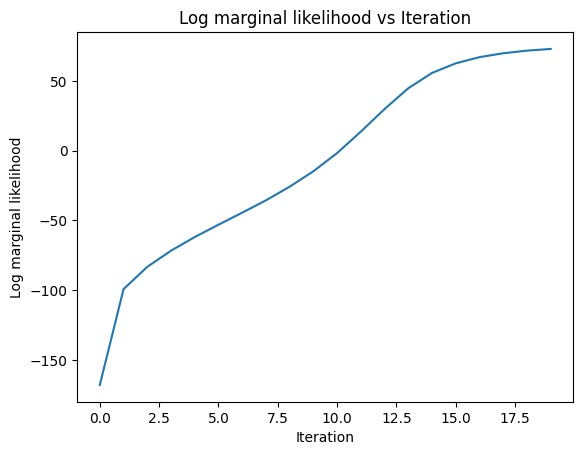

In [44]:
# plot log marginals
plt.plot(log_marginals,label='Estimated log marginal')
# plt.plot(true_logmarginal, label='True log marginal')
plt.xlabel('Iteration')
plt.ylabel('Log marginal likelihood')
plt.title('Log marginal likelihood vs Iteration')

In [45]:
# calculate log marginal over a grid of lengthscales and variances
lengthscales = torch.linspace(0.1, 8, 50)
variances = torch.linspace(0.1, 4, 50)
log_marginals_grid = torch.zeros((len(lengthscales), len(variances)))
for i, lengthscale in enumerate(lengthscales):
    for j, variance in enumerate(variances):
        kernel = SquaredExponential(dimension=1, lengthscale=lengthscale.item(), variance=variance.item())
        log_marginals_grid[i, j] = kernel.log_marginal(x, y, sigmasq)


/var/folders/w7/6nm4rxb53x55tjtr3b5k86b80000gn/T/ipykernel_8964/4293340682.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust layout to make space for the colorbar


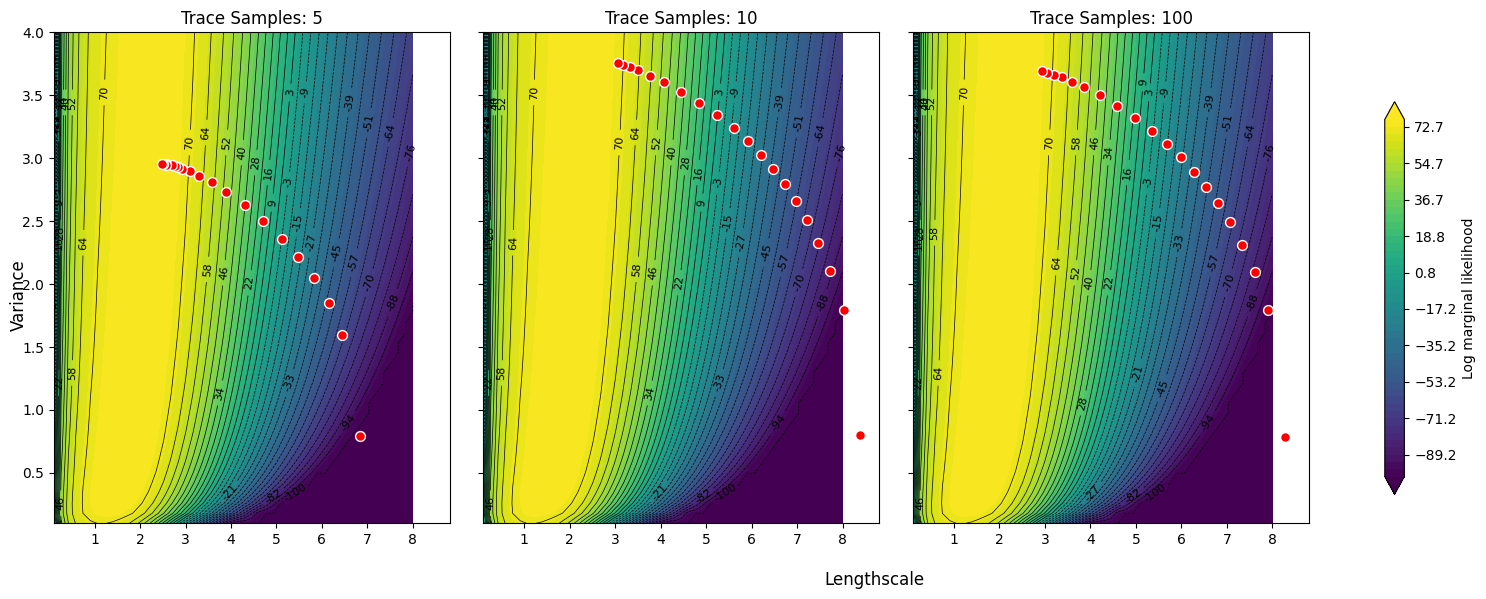

In [ ]:


# Clip values below -100 to prevent extreme low outliers
log_marginal_clipped = np.clip(log_marginals_grid, -100, log_marginals_grid.max())

# Set up filled contour levels (detailed)
fill_levels = np.linspace(-100, log_marginals_grid.max(), 50)
# Use fewer contour levels for the line overlay
line_levels = np.linspace(-100, log_marginals_grid.max(), 30)
import numpy as np
fig, axes = plt.subplots(1, len(results), figsize=(18, 6), sharex=True, sharey=True)

# Plot the same contour on all subplots
for i, ax in enumerate(axes):
    # Plot filled contours
    cf = ax.contourf(lengthscales, variances, log_marginal_clipped.T, levels=fill_levels, cmap='viridis', extend='both')

    # Overlay a reduced number of contour lines for clarity
    cs = ax.contour(lengthscales, variances, log_marginal_clipped.T, levels=line_levels, colors='k', linewidths=0.5)
    ax.clabel(cs, inline=True, fontsize=8, fmt='%1.0f')

    # Overlay tracked hyperparameter points for the current result
    tracked_lengthscales_arr = np.array(results[i]['tracked_lengthscales'])
    tracked_variances_arr = np.array(results[i]['tracked_variances'])
    ax.scatter(tracked_lengthscales_arr, tracked_variances_arr,
               color='red', edgecolors='w', s=50, label='Tracked points', zorder=10)

    # Set title for each subplot
    ax.set_title(f"Trace Samples: {results[i]['trace_samples']}", fontsize=12)

# Add a colorbar to the figure, placed outside
cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), label='Log marginal likelihood', shrink=0.85, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Label axes
fig.supxlabel('Lengthscale', fontsize=12)
fig.supylabel('Variance', fontsize=12)

plt.tight_layout(rect=[0, 0, 0.75, 1])  # Adjust layout to make space for the colorbar
plt.show()


In [ ]:
kernel = SquaredExponential(dimension=1, lengthscale=2.2, variance=2.5)
kernel.log_marginal(x, y, sigmasq)

tensor(-95.7088, dtype=torch.float64)

In [ ]:
log_marginals_grid

tensor([[975.3028, 526.8682, 404.9367,  ..., 723.1990, 725.4256, 727.6324],
        [361.9651,  52.5532,  21.8074,  ...,  81.4273,  81.7894,  82.1482],
        [203.1096,  -3.6453, -21.0356,  ...,  14.5652,  14.7714,  14.9758],
        ...,
        [591.7867, 336.1873, 276.7901,  ...,  31.4059,  31.1037,  30.8049],
        [595.9135, 339.3149, 280.1497,  ...,  33.0970,  32.7948,  32.4962],
        [600.0063, 342.3823, 283.4424,  ...,  34.7580,  34.4557,  34.1571]])

In [ ]:
tracked_lengthscales

array([7.35883654, 6.97218739, 6.68048781, 6.39328239, 6.0968172 ,
       5.79131425, 5.49223767, 5.16968012, 4.78761006, 4.41192231,
       4.02832199, 3.69870051, 3.45259412, 3.24814245, 3.07204195,
       2.94147405, 2.83061003, 2.73421068, 2.67913362, 2.61237624,
       2.53475644, 2.48671395, 2.46720752, 2.46797123, 2.43872901,
       2.44303541, 2.40142147, 2.36410397, 2.31699019, 2.29103188,
       2.27334705, 2.25605481, 2.25306202, 2.28060954, 2.26207283,
       2.2895714 , 2.28671503, 2.25322826, 2.24351827, 2.25723358,
       2.26265808, 2.24876871, 2.22208876, 2.21901089, 2.25506818,
       2.27534595, 2.27099433, 2.26696497, 2.26074043, 2.24582625,
       2.25665377, 2.24092719, 2.24649273, 2.25416375, 2.26318771,
       2.27489155, 2.26845844, 2.30091096, 2.26623854, 2.26225815,
       2.23880906, 2.2031245 , 2.2208155 , 2.23227714, 2.23542765,
       2.20915618, 2.21038112, 2.2434921 , 2.23515725, 2.22036559,
       2.2420377 , 2.22833087, 2.26334714, 2.23239144, 2.23838

$$\alpha = (K+\sigma^2 I)^{-1}y$$

$$\frac{\partial (K + \sigma^2 I)}{\partial \theta} = FD'F^* + \frac{\partial (\sigma^2 I)}{\partial \theta}$$
where 
$$D'_{jj} = h\frac{\partial }{\partial \theta} \hat{k}_\theta(\xi_j)

# note missing timing in efgp1d